In [1]:
## Imports
import time
import webbrowser
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import pickle

import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'g'

import time_series_functions as tsf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from fbprophet import Prophet

from sklearn.metrics import mean_squared_error, r2_score

plt.figure(figsize=(8, 16), dpi=80)

import autoreload
%load_ext autoreload
%autoreload 2

<Figure size 640x1280 with 0 Axes>

In [2]:
##Functions
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=200, freq='M'):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    count=0
    for comb in pdq:
        for combs in pdqs:
            try:
                count+=1
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq=freq)

                output = mod.fit(disp=False,maxiter=maxiter,method_kwargs={"warn_convergence": False}) 
                ans.append([comb, combs, output.bic])
                #print('SARIMAX {} x {} : BIC Calculated ={}'.format(comb, combs, output.bic))
                if count%10==0:
                    print(count)
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])
    ans_df=ans_df[~ans_df.duplicated(keep='first')]

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]
    ans_df=ans_df.reset_index(drop=True)
    
    return ans_df

def calculate_adfuller(time_series):
    result = adfuller(time_series.dropna(),autolag='AIC')
    return result[1]

In [3]:
##Loading gthe datset and cleaning dups
df=pd.read_csv('AEP_hourly.csv')
#print(df.dtypes,df.shape)
df=df.groupby('Datetime').AEP_MW.mean()
df=df.reset_index()

#creating the time series
df['Datetime']=pd.to_datetime(df['Datetime'])
new_df=df.set_index(['Datetime'])

new_df.sort_index(inplace=True)
##Creating full calendar
start=new_df.index[0]
end=new_df.index[-1]
full_calendar=pd.date_range(start, end,freq='H')
##Putting it all together
calendar=pd.DataFrame(full_calendar,columns=['Datetime']).set_index('Datetime')#,new_df.head()
final_df=calendar.join(new_df)
print(final_df.isnull().sum())
final_df=final_df.interpolate()
final_df.head()
print(final_df.isnull().sum())
hourly_df=final_df[['AEP_MW']].asfreq('H').copy()
daily_df=final_df[['AEP_MW']].resample('D').sum()[:-1]
weekly_df=final_df[['AEP_MW']].resample('W').sum()[1:-1]
monthly_df=final_df[['AEP_MW']].resample('M').sum()[3:-1]
quarterly_df=final_df[['AEP_MW']].resample('Q').sum()[1:-1]

AEP_MW    27
dtype: int64
AEP_MW    0
dtype: int64


# Quarterly

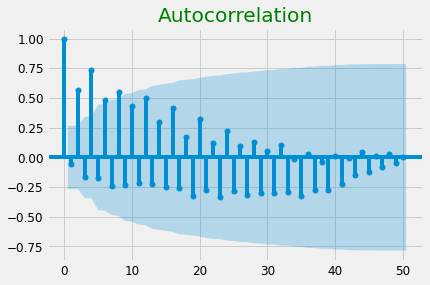

<Figure size 2160x1080 with 0 Axes>

In [13]:
##Determining seasonality
plot_acf(quarterly_df, lags=50)
plt.figure(figsize = (30, 15))
plt.show()

In [ ]:
##TimeSeries
ts=quarterly_df.loc['2005':'2018'].copy()
seasonality=4
ts_train=ts.loc['2005':'2016'].copy()
ts_test=ts.loc['2017':'2018'].copy()
periods_to_test=ts_test.shape[0]
freq='Q'
maxiter=300
d=0
p_value=1
while d<4:
    
    
    p_value=tsf.calculate_adfuller(ts_train)
    if p_value<=0.05:
        break
    else:
        d+=1
        ts_train=ts_train.diff()
ts_train= ts.iloc[:-periods_to_test].copy()
print('This is my d: ',d)
p=q=range(0,3)
to_perm=list(p)+list(q)
permutations=[list(x) for x in itertools.permutations(to_perm,2)]
pdq=[x.insert(1,d) or x for x in permutations]
pdq=[tuple(x) for x in pdq]
seasonal_pdq = [(x[0], x[1], x[2], seasonality) for x in pdq]
##Determining best parameters
outcome=sarimax_gridsearch(ts_train, pdq, seasonal_pdq,freq=freq)
#best_parameters={}
# open a file, where you stored the pickled data
file = open('best_parameters.pkl', 'rb')
best_parameters = pickle.load(file)
best_parameters['quarterly']=[(outcome.loc[0,'pdq']),(outcome.loc[0,'pdqs'])]
# open a file, where you ant to store the data
file = open('best_parameters.pkl', 'wb')

# dump information to that file
pickle.dump(best_parameters, file)

# close the file
file.close()
                               
#Build SARIMAX model w/optimal parameters
sarimax = sm.tsa.statespace.SARIMAX(ts_train,
                                    order=outcome.loc[0,'pdq'],
                                    seasonal_order=outcome.loc[0,'pdqs'],
                                    #enforce_stationarity=False,
                                    enforce_invertibility=False,
                                    freq=freq)
# Fit the model
output = sarimax.fit(disp=False,maxiter=maxiter,)#method_kwargs={"warn_convergence": False}
# Print output summary
print(output.summary())
# Plot diagnostics
output.plot_diagnostics(figsize=(16,10));
url = "https://www.youtube.com/watch?v=Udt-9J8nzGE"
webbrowser.open(url,new=1)

rmse:  1475407.96 r2:  0.03


<AxesSubplot:xlabel='Datetime'>

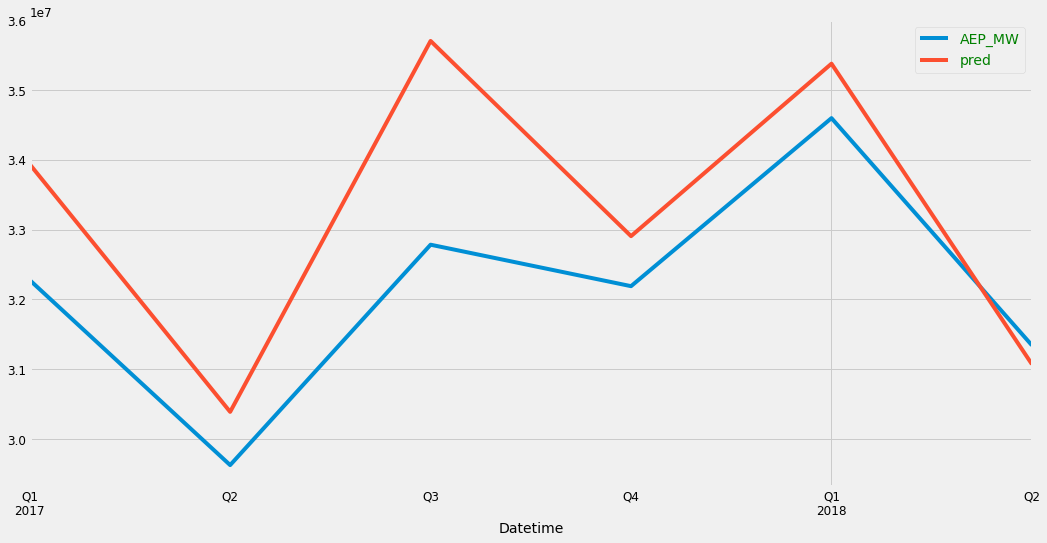

In [14]:
##TimeSeries
ts=quarterly_df.loc['2005':'2018'].copy()
seasonality=4
ts_train=ts.loc['2005':'2016'].copy()
ts_test=ts.loc['2017':'2018'].copy()
periods_to_test=ts_test.shape[0]
freq='Q'
maxiter=300

###Recovering parameters, if needed it
file = open('best_parameters.pkl', 'rb')
best_parameters = pickle.load(file)

# close the file
file.close()
pdq=best_parameters['quarterly'][0]
pdqs=best_parameters['quarterly'][1]
output = sm.tsa.statespace.SARIMAX(ts_train,
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,
                                    freq=freq).fit(disp=False,maxiter=maxiter,)#method_kwargs={"warn_convergence": False}

pred=output.predict(start = len(ts_train), end =len(ts_train)+periods_to_test, dynamic= True)
# pred.plot()
# ts_test.plot()
ts_test['pred']=pred
sarimax_rmse=round(np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.pred)),2)
sarimax_r2=round(r2_score(ts_test.AEP_MW,ts_test.pred),2)
print("rmse: ",sarimax_rmse,"r2: ", sarimax_r2)
ts_test.plot(figsize=(16,8))

In [ ]:
best_r2=-20
best_rmse=100000000
perc_rmse=0
perc_r2=0

for perc in np.linspace(0.7,1.2,20):
    sarimax_rmse=round(np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.pred*perc)),2)
    if sarimax_rmse<best_rmse:
        best_rmse=sarimax_rmse
        perc_rmse=perc
    sarimax_r2=round(r2_score(ts_test.AEP_MW,ts_test.pred*perc),2)
    if sarimax_r2>best_r2:
        best_r2=sarimax_r2
        perc_r2=perc
    #print(round(perc,2),sarimax_rmse, sarimax_r2)
print('R2', round(perc_r2,2),best_r2,'\nRMSE',round(perc_rmse,2), best_rmse)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -58.2776
Iteration  1. Log joint probability =    144.726. Improved by 203.004.
Iteration  2. Log joint probability =    170.587. Improved by 25.8606.
Iteration  3. Log joint probability =    195.003. Improved by 24.4158.
Iteration  4. Log joint probability =    214.468. Improved by 19.4653.
Iteration  5. Log joint probability =    218.181. Improved by 3.71331.
Iteration  6. Log joint probability =    218.609. Improved by 0.42824.
Iteration  7. Log joint probability =    219.625. Improved by 1.01552.
Iteration  8. Log joint probability =    219.851. Improved by 0.225928.
Iteration  9. Log joint probability =    220.754. Improved by 0.902776.
Iteration 10. Log joint probability =    222.958. Improved by 2.20455.
Iteration 11. Log joint probability =    224.134. Improved by 1.17573.
Iteration 12. Log joint probability =    225.303. Improved by 1.16951.
Iteration 13. Log joint probability =    227.763. Improved by 2.45981.
Iteration 14. Log joint probabili

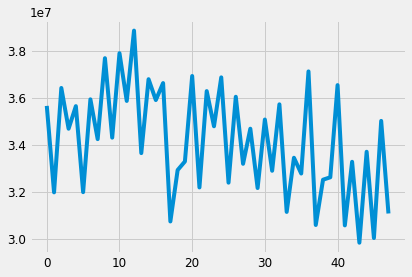

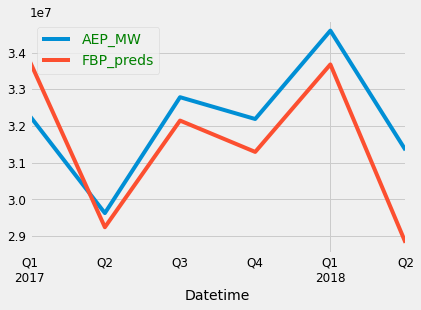

In [15]:
#Prophet
ts=quarterly_df.loc['2005':'2018'].copy()
seasonality=4
ts_train=ts.loc['2005':'2016'].copy()
ts_test=ts.loc['2017':'2018'].copy()
periods_to_test=ts_test.shape[0]
freq='Q'

####Prepping for Prophet
ts_train=ts_train.reset_index()

ts_train.rename(columns={'AEP_MW':'y','Datetime':'ds'}, inplace = True)
ts_train.y.plot()
ts_train['y'] = np.log(ts_train['y'])
model = Prophet()
model.fit(ts_train)
future = model.make_future_dataframe(periods=periods_to_test, freq = 'Q')
forecast = model.predict(future)
pro_preds=forecast.set_index('ds').yhat.tail(periods_to_test).values
ts_test['FBP_preds']=np.exp(pro_preds)
ts_test[['AEP_MW','FBP_preds']].plot()
prophet_rmse=round(np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.FBP_preds)),2)
prophet_r2=round(r2_score(ts_test.AEP_MW,ts_test.FBP_preds),2)
print("RMSE: ",prophet_rmse,"\nR2: ",prophet_r2)

In [ ]:
best_r2=-20
best_rmse=10000000
perc_rmse=0
perc_r2=0

for perc in np.linspace(0.7,1.2,20):
    prophet_rmse=round(np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.FBP_preds*perc)),2)
    if prophet_rmse<best_rmse:
        best_rmse=prophet_rmse
        perc_rmse=perc
    prophet_r2=round(r2_score(ts_test.AEP_MW,ts_test.FBP_preds*perc),2)
    if prophet_r2>best_r2:
        best_r2=prophet_r2
        perc_r2=perc
    #print(round(perc,2),sarimax_rmse, sarimax_r2)
print('R2', round(perc_r2,2),best_r2,'\nRMSE',round(perc_rmse,2), best_rmse)

In [ ]:
model.plot(forecast)

# And the winner is

In [16]:
if round(sarimax_r2-prophet_r2,2) >0:
    print('Sarimax WINS')
elif round(sarimax_r2-prophet_r2,2) <0:
    print('Prophet WINS')
else:
    print('It is a tie')


Prophet WINS


# Monthly Analysis

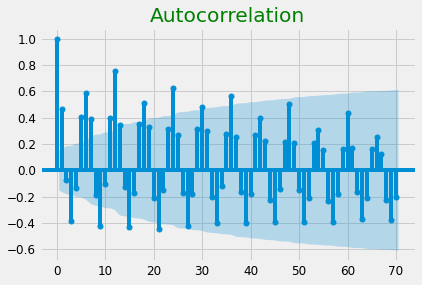

In [4]:
##Determining seasonality
plot_acf(monthly_df, lags=70)
plt.show()

This is my d:  2
10
20
30
40


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


50


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


60
70
80
90
100
110
120
130


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


140


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


150
160
170
180


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


190


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


200


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


210
220
230
240
250
260
270


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


280


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


290


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


530


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


540
550
560
570
580


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


590


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


600
610
620
630
640
650
660


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


670


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


680


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


690
700
710
720


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


730


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


740


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
                                      SARIMAX Results                                      
Dep. Variable:                              AEP_MW   No. Observations:                  108
Model:             SARIMAX(2, 2, 2)x(2, 2, [], 12)   Log Likelihood               -1237.955
Date:                             Tue, 18 Jan 2022   AIC                           2489.909
Time:                                     17:42:34   BIC                           2506.756
Sample:                                 01-31-2008   HQIC                          2496.673
                                      - 12-31-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3442      0.527     -0.65

True

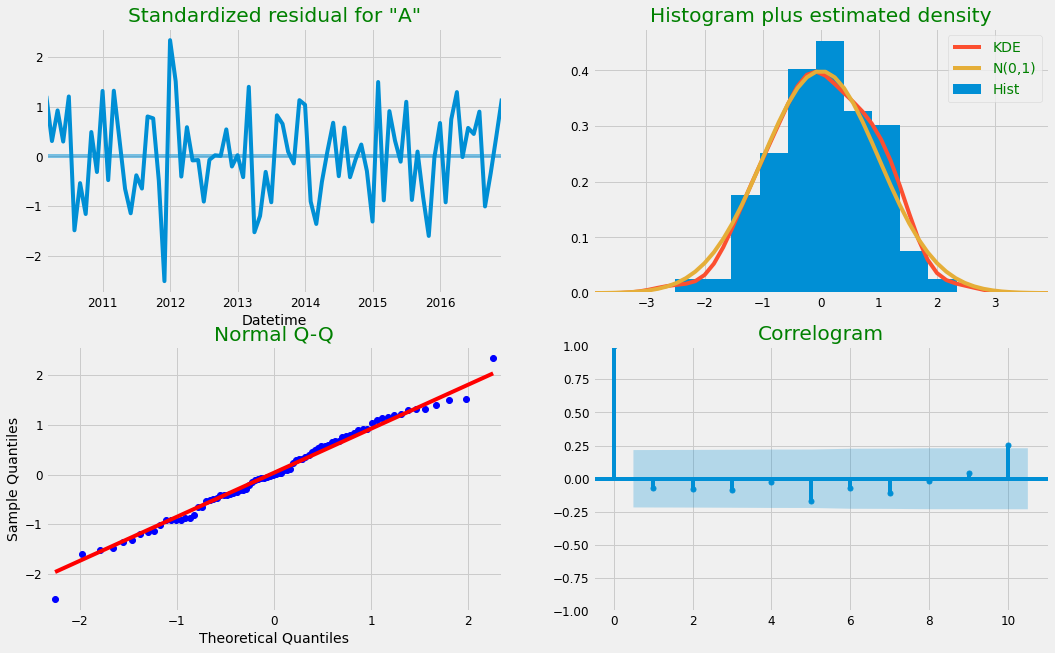

In [5]:
##TimeSeries
ts=monthly_df.loc['2008':'2018'].copy()
seasonality=12
ts_train=ts.loc['2005':'2016'].copy()
ts_test=ts.loc['2017':'2018'].copy()
periods_to_test=ts_test.shape[0]
freq='M'
maxiter=300
d=0
p_value=1
while d<4:
    
    
    p_value=tsf.calculate_adfuller(ts_train)
    if p_value<=0.05:
        break
    else:
        d+=1
        ts_train=ts_train.diff()
ts_train= ts.iloc[:-periods_to_test].copy()
print('This is my d: ',d)
p=q=range(0,3)
to_perm=list(p)+list(q)
permutations=[list(x) for x in itertools.permutations(to_perm,2)]
pdq=[x.insert(1,d) or x for x in permutations]
pdq=[tuple(x) for x in pdq]
seasonal_pdq = [(x[0], x[1], x[2], seasonality) for x in pdq]
##Determining best parameters
outcome=sarimax_gridsearch(ts_train, pdq, seasonal_pdq,freq=freq)
# open a file, where you stored the pickled data
file = open('best_parameters.pkl', 'rb')
best_parameters = pickle.load(file)

# close the file
file.close()

best_parameters['monthly']=[(outcome.loc[0,'pdq']),(outcome.loc[0,'pdqs'])]
# open a file, where you ant to store the data
file = open('best_parameters.pkl', 'wb')

# dump information to that file
pickle.dump(best_parameters, file)

# close the file
file.close()
        
                             

#Build SARIMAX model w/optimal parameters
sarimax = sm.tsa.statespace.SARIMAX(ts_train,
                                    order=outcome.loc[0,'pdq'],
                                    seasonal_order=outcome.loc[0,'pdqs'],
                                    #enforce_stationarity=False,
                                    enforce_invertibility=False,
                                    freq=freq)
# Fit the model
output = sarimax.fit(disp=False,maxiter=maxiter,)#method_kwargs={"warn_convergence": False}
# Print output summary
print(output.summary())
# Plot diagnostics
output.plot_diagnostics(figsize=(16,10));
url = "https://www.youtube.com/watch?v=Udt-9J8nzGE"
webbrowser.open(url,new=1)

(2907915.4, -8.51)

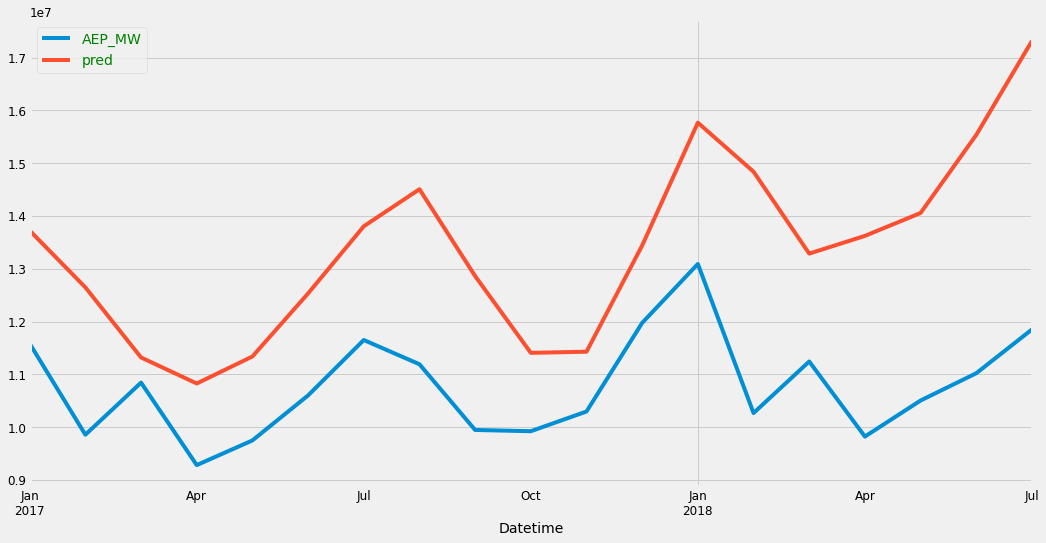

In [6]:
##TimeSeries
ts=monthly_df.loc['2005':'2018'].copy()
seasonality=12
ts_train=ts.loc['2005':'2016'].copy()
ts_test=ts.loc['2017':'2018'].copy()
periods_to_test=ts_test.shape[0]
freq='M'
maxiter=300

###Recovering parameters, if needed it
file = open('best_parameters.pkl', 'rb')
best_parameters = pickle.load(file)

# close the file
file.close()
pdq=best_parameters['monthly'][0]
pdqs=best_parameters['monthly'][1]

sarimax = sm.tsa.statespace.SARIMAX(ts_train,
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,
                                    freq=freq)
# Fit the model
output = sarimax.fit(disp=False,maxiter=maxiter,)#method_kwargs={"warn_convergence": False}
pred=output.predict(start = len(ts_train), end =len(ts_train)+periods_to_test, dynamic= True)
# pred.plot()
# ts_test.plot()
ts_test['pred']=pred
ts_test.plot(figsize=(16,8))
sarimax_rmse=round(np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.pred)),2)
sarimax_r2=round(r2_score(ts_test.AEP_MW,ts_test.pred),2)
sarimax_rmse, sarimax_r2

In [ ]:
best_r2=-20
best_rmse=1000000
perc_rmse=0
perc_r2=0

for perc in np.linspace(0.7,1.2,20):
    sarimax_rmse=round(np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.pred*perc)),2)
    if sarimax_rmse<best_rmse:
        best_rmse=sarimax_rmse
        perc_rmse=perc
    sarimax_r2=round(r2_score(ts_test.AEP_MW,ts_test.pred*perc),2)
    if sarimax_r2>best_r2:
        best_r2=sarimax_r2
        perc_r2=perc
    #print(round(perc,2),sarimax_rmse, sarimax_r2)
print('R2', round(perc_r2,2),best_r2,'\nRMSE',round(perc_rmse,2), best_rmse)

In [ ]:
sarimax_rmse=round(np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.pred)),2)
sarimax_r2=round(r2_score(ts_test.AEP_MW,ts_test.pred),2)
sarimax_rmse, sarimax_r2

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02339
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       800.973    0.00051075       530.539           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       803.804   4.34062e-05       197.667           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       806.819    0.00262559       2131.04           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        808.82   0.000665171       869.155      0.2781           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       809.253     0.0013115       518.941           1           1      577   
    Iter      log prob        ||dx||      ||grad||       alpha  

(655403.72, 0.52)

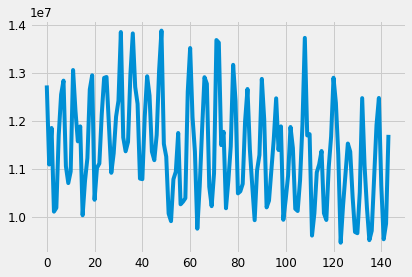

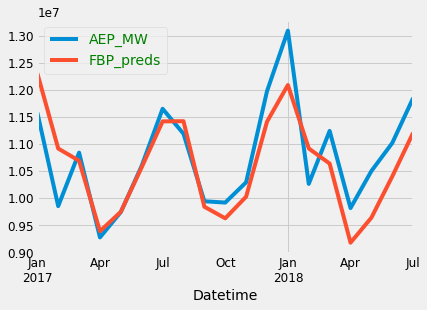

In [19]:
#Prophet
ts=monthly_df.loc['2005':'2018'].copy()
seasonality=12
ts_train=ts.loc['2005':'2016'].copy()
ts_test=ts.loc['2017':'2018'].copy()
periods_to_test=ts_test.shape[0]
freq='M'
####Prepping for Prophet
ts_train=ts_train.reset_index()
ts_train

ts_train.rename(columns={'AEP_MW':'y','Datetime':'ds'}, inplace = True)
ts_train.y.plot()
ts_train['y'] = np.log(ts_train['y'])
model = Prophet()
model.fit(ts_train)
future = model.make_future_dataframe(periods=periods_to_test, freq = 'M')
forecast = model.predict(future)
forecast = model.predict(future)
pro_preds=forecast.set_index('ds').yhat.tail(periods_to_test).values
ts_test['FBP_preds']=np.exp(pro_preds)
ts_test[['AEP_MW','FBP_preds']].plot()
prophet_rmse=round(np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.FBP_preds*1.05)),2)
prophet_r2=round(r2_score(ts_test.AEP_MW,ts_test.FBP_preds*1.05),2)
prophet_rmse,prophet_r2

In [ ]:
best_r2=-20
best_rmse=10000000
perc_rmse=0
perc_r2=0

for perc in np.linspace(0.7,1.2,20):
    prophet_rmse=round(np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.FBP_preds*perc)),2)
    if prophet_rmse<best_rmse:
        best_rmse=prophet_rmse
        perc_rmse=perc
    prophet_r2=round(r2_score(ts_test.AEP_MW,ts_test.FBP_preds*perc),2)
    if prophet_r2>best_r2:
        best_r2=prophet_r2
        perc_r2=perc
    #print(round(perc,2),sarimax_rmse, sarimax_r2)
print('R2', round(perc_r2,2),best_r2,'\nRMSE',round(perc_rmse,2), best_rmse)

In [ ]:
prophet_error=round(np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.FBP_preds)),2)
print("Error with FBProphet: ", prophet_error)
model.plot(forecast)

# And the winner is

In [20]:
if round(sarimax_r2-prophet_r2,2) >0:
    print('Sarimax WINS')
elif round(sarimax_r2-prophet_r2,2) <0:
    print('Prophet WINS')
else:
    print('It is a tie')


Prophet WINS


# Weekly analysis

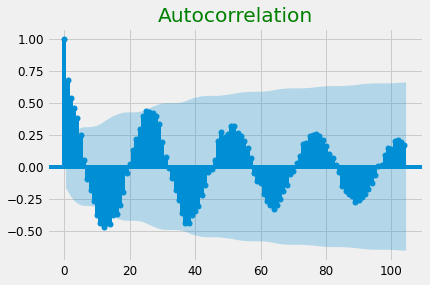

In [21]:
##Determining seasonality
plot_acf(weekly_df.loc['2016':'2018'], lags=104)
plt.show()

In [ ]:
##TimeSeries
ts=weekly_df.loc['2016':'2018'].copy()
seasonality=26
freq='W'

ts_test=ts.loc['2018'].copy()
ts_train=ts.loc['2016':'2017'].copy()
periods_to_test=ts_test.shape[0]
maxiter=100
d=0
p_value=1
while d<4:
    
    
    p_value=tsf.calculate_adfuller(ts_train)
    if p_value<=0.05:
        break
    else:
        d+=1
        ts_train=ts_train.diff()
ts_train=ts.iloc[:-periods_to_test].copy()
print('This is my d: ',d)
p=q=range(0,3)
to_perm=list(p)+list(q)
permutations=[list(x) for x in itertools.permutations(to_perm,2)]
pdq=[x.insert(1,d) or x for x in permutations]
pdq=[tuple(x) for x in pdq]
seasonal_pdq = [(x[0], x[1], x[2], seasonality) for x in pdq]
##Determining best parameters
outcome=sarimax_gridsearch(ts_train, pdq, seasonal_pdq,freq=freq)
# open a file, where you stored the pickled data
file = open('best_parameters.pkl', 'rb')
best_parameters = pickle.load(file)

# close the file
file.close()

best_parameters['weekly']=[(outcome.loc[0,'pdq']),(outcome.loc[0,'pdqs'])]
# open a file, where you ant to store the data
file = open('best_parameters.pkl', 'wb')

# dump information to that file
pickle.dump(best_parameters, file)

# close the file
file.close()
        
                             

#Build SARIMAX model w/optimal parameters
sarimax = sm.tsa.statespace.SARIMAX(ts_train,
                                    order=outcome.loc[0,'pdq'],
                                    seasonal_order=outcome.loc[0,'pdqs'],
                                    #enforce_stationarity=False,
                                    enforce_invertibility=False,
                                    freq=freq)
# Fit the model
output = sarimax.fit(disp=False,maxiter=maxiter,)#method_kwargs={"warn_convergence": False}
# Print output summary
print(output.summary())
# Plot diagnostics
output.plot_diagnostics(figsize=(16,10));
url = "https://www.youtube.com/watch?v=Udt-9J8nzGE"
webbrowser.open(url,new=1)

212450.06 0.37


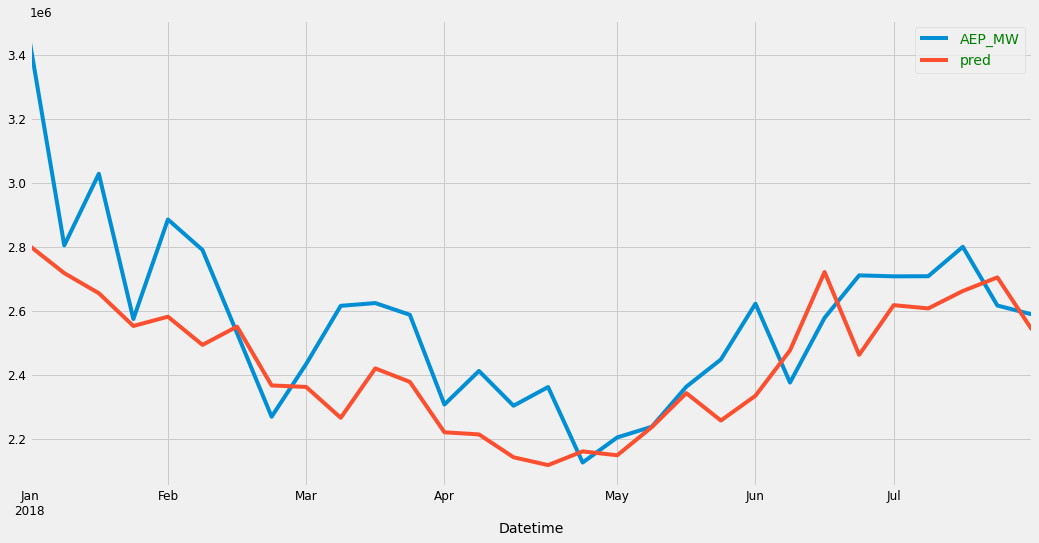

In [22]:
##TimeSeries
ts=s=weekly_df.loc['2014':'2018'].copy()
seasonality=26
freq='W'
ts_test=ts.loc['2018'].copy()
ts_train=ts.loc['2014':'2017'].copy()
periods_to_test=ts_test.shape[0]
maxiter=300

###Recovering parameters, if needed it
file = open('best_parameters.pkl', 'rb')
best_parameters = pickle.load(file)

# close the file
file.close()
pdq=best_parameters['weekly'][0]
pdqs=best_parameters['weekly'][1]

sarimax = sm.tsa.statespace.SARIMAX(ts_train,
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,
                                    freq=freq)
# Fit the model
output = sarimax.fit(disp=False,maxiter=maxiter,)#method_kwargs={"warn_convergence": False}
pred=output.predict(start = len(ts_train), end =len(ts_train)+periods_to_test, dynamic= True)
# pred.plot()
# ts_test.plot()
ts_test['pred']=pred
ts_test.plot(figsize=(16,8))
sarimax_rmse=round(np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.pred)),2)
sarimax_r2=round(r2_score(ts_test.AEP_MW,ts_test.pred),2)
print(sarimax_rmse, sarimax_r2)

In [ ]:
best_r2=-20
best_rmse=1000000
perc_rmse=0
perc_r2=0

for perc in np.linspace(0.7,1.2,20):
    sarimax_rmse=round(np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.pred*perc)),2)
    if sarimax_rmse<best_rmse:
        best_rmse=sarimax_rmse
        perc_rmse=perc
    sarimax_r2=round(r2_score(ts_test.AEP_MW,ts_test.pred*perc),2)
    if sarimax_r2>best_r2:
        best_r2=sarimax_r2
        perc_r2=perc
    #print(round(perc,2),sarimax_rmse, sarimax_r2)
print('R2', round(perc_r2,2),best_r2,'\nRMSE',round(perc_rmse,2), best_rmse)

In [ ]:

sarimax_rmse=round(np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.pred)),2)
sarimax_r2=round(r2_score(ts_test.AEP_MW,ts_test.pred),2)
print(sarimax_rmse, sarimax_r2)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.03716
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1057.4   0.000516207       595.042      0.6003      0.6003      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       1058.47   5.14458e-05       234.971   2.273e-07       0.001      204  LS failed, Hessian reset 
     199       1059.45   0.000208455       155.951           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       1059.61   1.06638e-05       174.521   9.798e-08       0.001      356  LS failed, Hessian reset 
     288       1059.73   1.31554e-05       218.167   1.071e-07       0.001      478  LS failed, Hessian reset 
     299       1059.76   0.000236826       216.008           1           1      491   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

(298478.29, -0.24)

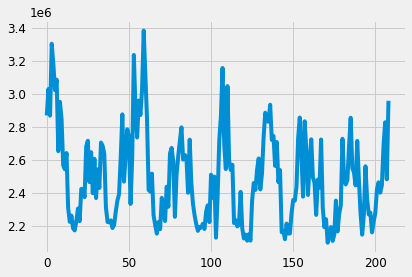

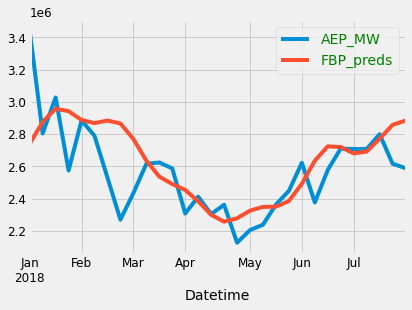

In [23]:
#Prophet
ts=weekly_df.loc['2014':'2018'].copy()
seasonality=26
ts_train=ts.loc['2014':'2017'].copy()
ts_test=ts.loc['2018'].copy()
periods_to_test=ts_test.shape[0]
freq='W'
####Prepping for Prophet
ts_train=ts_train.reset_index()
ts_train

ts_train.rename(columns={'AEP_MW':'y','Datetime':'ds'}, inplace = True)
ts_train.y.plot()
ts_train['y'] = np.log(ts_train['y'])
model = Prophet()
model.fit(ts_train)
future = model.make_future_dataframe(periods=periods_to_test, freq = 'W')
forecast = model.predict(future)
pro_preds=forecast.set_index('ds').yhat.tail(periods_to_test).values
ts_test['FBP_preds']=np.exp(pro_preds)
ts_test[['AEP_MW','FBP_preds']].plot()
prophet_rmse=round(np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.FBP_preds*1.05)),2)
prophet_r2=round(r2_score(ts_test.AEP_MW,ts_test.FBP_preds*1.05),2)
prophet_rmse,prophet_r2

In [ ]:
best_r2=-20
best_rmse=100000
perc_rmse=0
perc_r2=0

for perc in np.linspace(0.7,1.2,20):
    prophet_rmse=round(np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.FBP_preds*perc)),2)
    if prophet_rmse<best_rmse:
        best_rmse=prophet_rmse
        perc_rmse=perc
    prophet_r2=round(r2_score(ts_test.AEP_MW,ts_test.FBP_preds*perc),2)
    if prophet_r2>best_r2:
        best_r2=prophet_r2
        perc_r2=perc
    #print(round(perc,2),sarimax_rmse, sarimax_r2)
print('R2', round(perc_r2,2),best_r2,'\nRMSE',round(perc_rmse,2), best_rmse)

In [ ]:
prophet_rmse=round(np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.FBP_preds*1.05)),2)
prophet_r2=round(r2_score(ts_test.AEP_MW,ts_test.FBP_preds*1.05),2)
prophet_rmse,prophet_r2

In [ ]:
prophet_error=round(np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.FBP_preds)),2)
print("Error with FBProphet: ", prophet_error)
model.plot(forecast)

In [24]:
if round(sarimax_rmse-prophet_rmse,2) <0:
    print('Sarimax WINS')
elif round(sarimax_rmse-prophet_rmse,2) >0:
    print('Prophet WINS')
else:
    print('It is a tie')


Sarimax WINS


# Daily analysis

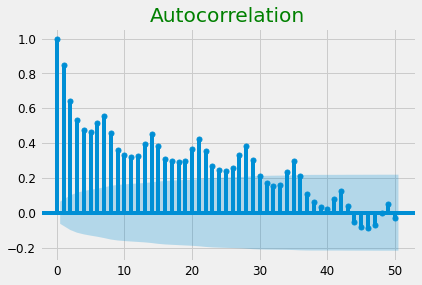

In [25]:
##Determining seasonality
plot_acf(daily_df.loc['2016':'2018'], lags=50)
plt.show()

In [ ]:
##TimeSeries
ts=daily_df.loc['2012':'2018'].copy()
seasonality=7
freq='D'

ts_test=ts.loc['2018'].copy()
ts_train=ts.loc['2012':'2017'].copy()
periods_to_test=ts_test.shape[0]
maxiter=100
d=0
p_value=1
while d<4:
    
    
    p_value=calculate_adfuller(ts_train)
    if p_value<=0.05:
        break
    else:
        d+=1
        ts_train=ts_train.diff()
ts_train=ts.iloc[:-periods_to_test].copy()
print('This is my d: ',d)
p=q=range(0,3)
to_perm=list(p)+list(q)
permutations=[list(x) for x in itertools.permutations(to_perm,2)]
pdq=[x.insert(1,d) or x for x in permutations]
pdq=[tuple(x) for x in pdq]
seasonal_pdq = [(x[0], x[1], x[2], seasonality) for x in pdq]
##Determining best parameters
outcome=sarimax_gridsearch(ts_train, pdq, seasonal_pdq,freq=freq)
# open a file, where you stored the pickled data
file = open('best_parameters.pkl', 'rb')
best_parameters = pickle.load(file)

# close the file
file.close()

best_parameters['daily']=[(outcome.loc[0,'pdq']),(outcome.loc[0,'pdqs'])]
# open a file, where you want to store the data
file = open('best_parameters.pkl', 'wb')

# dump information to that file
pickle.dump(best_parameters, file)

# close the file
file.close()
        
                             

#Build SARIMAX model w/optimal parameters
sarimax = sm.tsa.statespace.SARIMAX(ts_train,
                                    order=outcome.loc[0,'pdq'],
                                    seasonal_order=outcome.loc[0,'pdqs'],
                                    #enforce_stationarity=False,
                                    enforce_invertibility=False,
                                    freq=freq)
# Fit the model
output = sarimax.fit(disp=False,maxiter=maxiter,)#method_kwargs={"warn_convergence": False}
# Print output summary
print(output.summary())
# Plot diagnostics
output.plot_diagnostics(figsize=(16,10));
url = "https://www.youtube.com/watch?v=Udt-9J8nzGE"
webbrowser.open(url,new=1)

39282.67 0.25


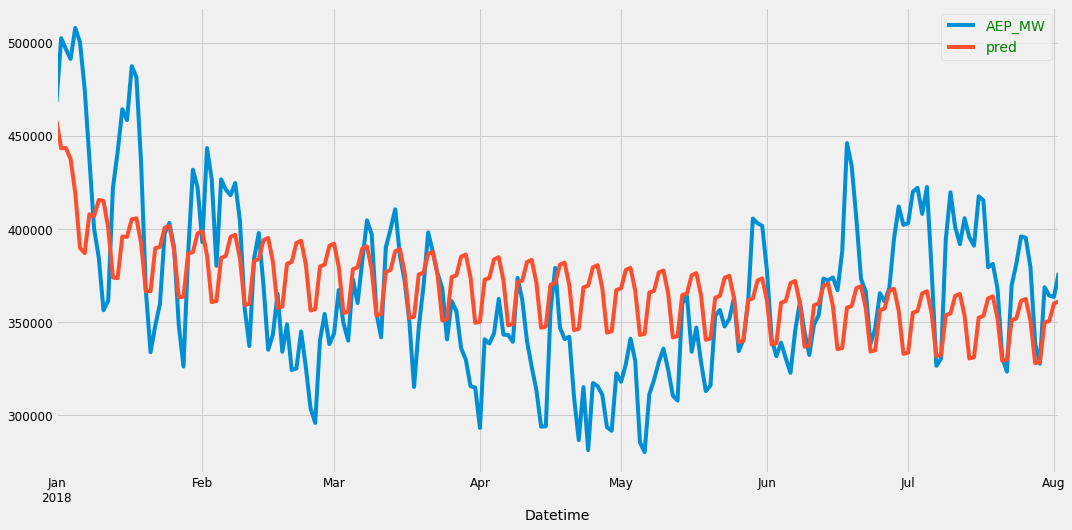

In [26]:
##TimeSeries
ts=daily_df.loc['2012':'2018'].copy()
seasonality=7
freq='D'

ts_test=ts.loc['2018'].copy()
ts_train=ts.loc['2012':'2017'].copy()
periods_to_test=ts_test.shape[0]
maxiter=300

###Recovering parameters, if needed it
file = open('best_parameters.pkl', 'rb')
best_parameters = pickle.load(file)

# close the file
file.close()
pdq=best_parameters['daily'][0]
pdqs=best_parameters['daily'][1]

sarimax = sm.tsa.statespace.SARIMAX(ts_train,
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,
                                    freq=freq)
# Fit the model
output = sarimax.fit(disp=False,maxiter=maxiter,)#method_kwargs={"warn_convergence": False}
pred=output.predict(start = len(ts_train), end =len(ts_train)+periods_to_test, dynamic= True)
# pred.plot()
# ts_test.plot()
ts_test['pred']=pred
ts_test.plot(figsize=(16,8))
sarimax_rmse=round(np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.pred)),2)
sarimax_r2=round(r2_score(ts_test.AEP_MW,ts_test.pred),2)
print(sarimax_rmse, sarimax_r2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.219
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         10154   0.000458125        1052.8           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10187.3   0.000585559       1341.96           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       10194.7    0.00216211       3633.49      0.3527           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       10199.4   0.000852482       1561.15           1           1      472   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499         10216   0.000457294       464.789           1           1      584   
    Iter      log prob        ||dx||      ||grad||       alpha    

(39271.24, 0.25)

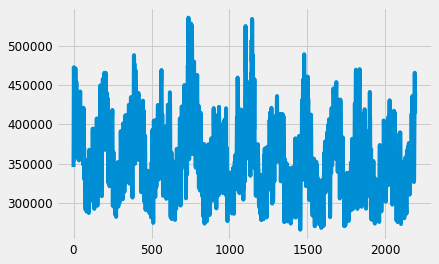

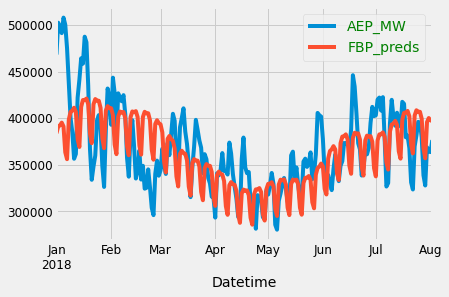

In [27]:
#Prophet
ts=daily_df.loc['2012':'2018'].copy()
seasonality=7
ts_train=ts.loc['2012':'2017'].copy()
ts_test=ts.loc['2018'].copy()
periods_to_test=ts_test.shape[0]
freq='D'
####Prepping for Prophet
ts_train=ts_train.reset_index()
ts_train

ts_train.rename(columns={'AEP_MW':'y','Datetime':'ds'}, inplace = True)
ts_train.y.plot()
ts_train['y'] = np.log(ts_train['y'])
model = Prophet()
model.fit(ts_train)
future = model.make_future_dataframe(periods=periods_to_test, freq = 'D')
forecast = model.predict(future)
pro_preds=forecast.set_index('ds').yhat.tail(periods_to_test).values
ts_test['FBP_preds']=np.exp(pro_preds)
ts_test[['AEP_MW','FBP_preds']].plot()
prophet_rmse=round(np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.FBP_preds*1.05)),2)
prophet_r2=round(r2_score(ts_test.AEP_MW,ts_test.FBP_preds*1.05),2)
prophet_rmse,prophet_r2

In [28]:
if round(sarimax_rmse-prophet_rmse,2) <0:
    print('Sarimax WINS')
elif round(sarimax_rmse-prophet_rmse,2) >0:
    print('Prophet WINS')
else:
    print('It is a tie')


Prophet WINS


# Hourly Analysis

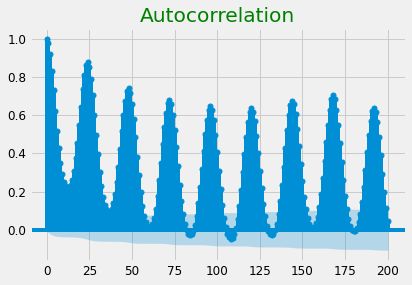

In [29]:
##Determining seasonality
plot_acf(hourly_df.loc['2016':'2018'], lags=200)
plt.show()

This is my d:  1


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


10


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


20


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


30


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


40


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


50


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


60


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


70


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


80


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


90


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


100


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


110


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


120


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


130


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


140


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


150


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


160
170


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


180


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


190


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


200


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


210


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


220
230


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


240


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


250


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


260


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


270


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


280


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


290


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


300


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


310


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


320


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


330


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


340


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


350


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


360


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


370


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


380


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


390


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


400


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


410


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


420


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


430


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


440


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


450


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


460


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


470


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


480


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


490


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


500


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


510


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


520


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


530


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


540


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


550


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


560


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


570


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


580


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


590


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


600


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


610
620


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


630


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


640


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


650


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


660


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


670


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


680


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


690


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


700
710


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


720


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


730


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


740


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


750


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


760


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


770


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


780


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


790


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


800


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


810


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


820


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


830


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


840


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


850


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


860


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


870


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


880


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


890


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


900
                                     SARIMAX Results                                      
Dep. Variable:                             AEP_MW   No. Observations:                  200
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 24)   Log Likelihood               -1111.454
Date:                            Wed, 05 Jan 2022   AIC                           2232.908
Time:                                    13:12:16   BIC                           2248.732
Sample:                                07-21-2018   HQIC                          2239.327
                                     - 07-29-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5595      0.072      7.750      0.000       0.418       0.701
ar.L2          0.0328      0.08

True

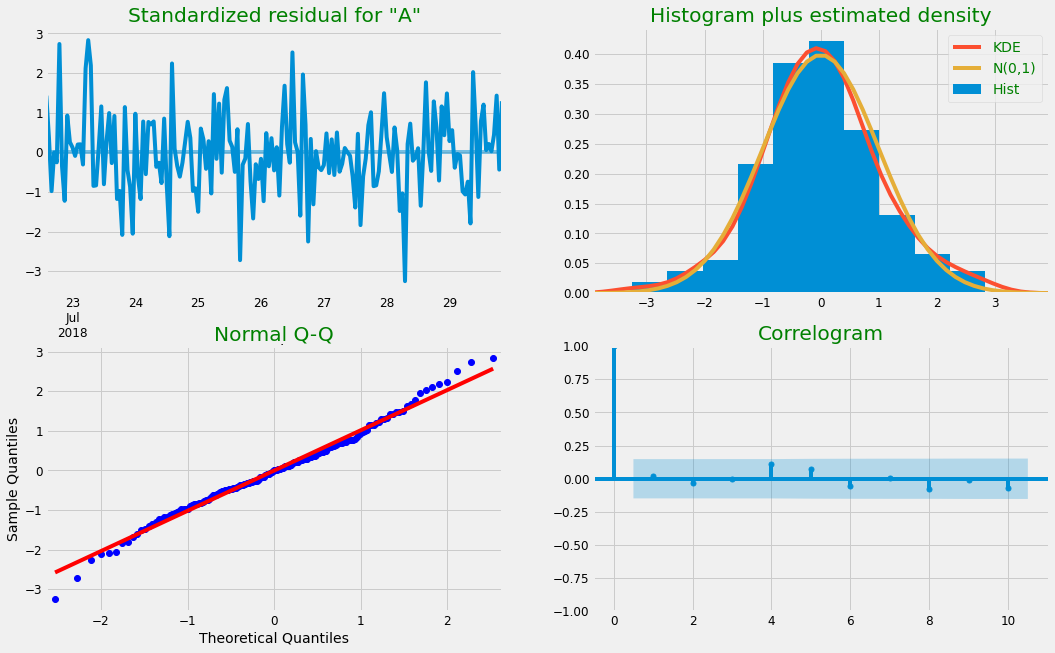

In [4]:
##TimeSeries
ts=hourly_df[-300:].copy()
seasonality=24
freq='H'
ts_test=ts[-48:].copy()
ts_train=ts[:-48].copy()
# ts_test=ts[-int(ts.shape[0]*0.2):].copy()
# ts_train=ts[:-int(ts.shape[0]*0.2)].copy()
periods_to_test=ts_test.shape[0]
maxiter=100
d=0
p_value=1
while d<4:
    
    
    p_value=calculate_adfuller(ts_train)
    if p_value<=0.05:
        break
    else:
        d+=1
        ts_train=ts_train.diff()
#ts_train=ts[:-int(ts.shape[0]*0.2)].copy()
ts_train=ts[:-100].copy()
print('This is my d: ',d)
p=q=range(0,3)
to_perm=list(p)+list(q)
permutations=[list(x) for x in itertools.permutations(to_perm,2)]
pdq=[x.insert(1,d) or x for x in permutations]
pdq=[tuple(x) for x in pdq]
seasonal_pdq = [(x[0], x[1], x[2], seasonality) for x in pdq]
##Determining best parameters
outcome=sarimax_gridsearch(ts_train, pdq, seasonal_pdq,freq=freq)
# open a file, where you stored the pickled data
file = open('best_parameters.pkl', 'rb')
best_parameters = pickle.load(file)

# close the file
file.close()

best_parameters['hourly']=[(outcome.loc[0,'pdq']),(outcome.loc[0,'pdqs'])]
# open a file, where you want to store the data
file = open('best_parameters.pkl', 'wb')

# dump information to that file
pickle.dump(best_parameters, file)

# close the file
file.close()
        
                             

#Build SARIMAX model w/optimal parameters
sarimax = sm.tsa.statespace.SARIMAX(ts_train,
                                    order=outcome.loc[0,'pdq'],
                                    seasonal_order=outcome.loc[0,'pdqs'],
                                    #enforce_stationarity=False,
                                    enforce_invertibility=False,
                                    freq=freq)
# Fit the model
output = sarimax.fit(disp=False,maxiter=maxiter,)#method_kwargs={"warn_convergence": False}
# Print output summary
print(output.summary())
# Plot diagnostics
output.plot_diagnostics(figsize=(16,10));
url = "https://www.youtube.com/watch?v=Udt-9J8nzGE"
webbrowser.open(url,new=1)

479.13 0.95


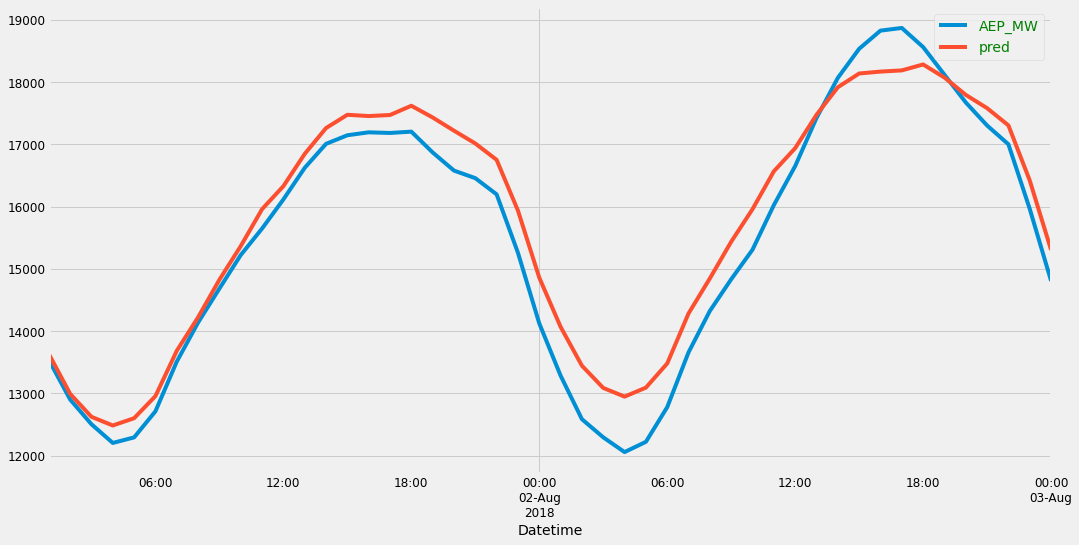

In [6]:
##TimeSeries

ts=hourly_df[-300:].copy()
seasonality=24
freq='H'
ts_test=ts[-48:].copy()
ts_train=ts[:-48].copy()
periods_to_test=ts_test.shape[0]

###Recovering parameters, if needed it
file = open('best_parameters.pkl', 'rb')
best_parameters = pickle.load(file)

# close the file
file.close()
pdq=best_parameters['hourly'][0]
pdqs=best_parameters['hourly'][1]

sarimax = sm.tsa.statespace.SARIMAX(ts_train,
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,
                                    freq=freq)
# Fit the model
output = sarimax.fit(disp=False,maxiter=maxiter,)#method_kwargs={"warn_convergence": False}
pred=output.predict(start = len(ts_train), end =len(ts_train)+periods_to_test, dynamic= True)
# pred.plot()
# ts_test.plot()
ts_test['pred']=pred
ts_test.plot(figsize=(16,8))
sarimax_rmse=round(np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.pred)),2)
sarimax_r2=round(r2_score(ts_test.AEP_MW,ts_test.pred),2)
print(sarimax_rmse, sarimax_r2)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Initial log joint probability = -2.05206
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1305.88    0.00161184       1069.64           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1327.49    0.00216978       1297.33           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1336.34    0.00298411       1002.01           1           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1345.96    0.00178244       1229.86      0.2136      0.8813      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1347.69    0.00429021       557.226           1           1      589   
    Iter      log prob        ||dx||      ||grad||       alpha  

(973.32, 0.78)

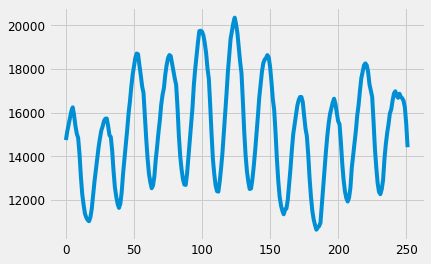

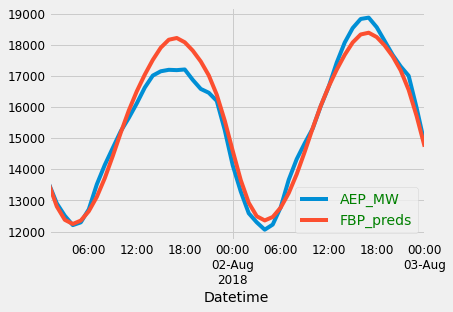

In [8]:
#Prophet
s=hourly_df[-300:].copy()
seasonality=24
freq='H'
ts_test=ts[-48:].copy()
ts_train=ts[:-48].copy()

####Prepping for Prophet
ts_train=ts_train.reset_index()
ts_train

ts_train.rename(columns={'AEP_MW':'y','Datetime':'ds'}, inplace = True)
ts_train.y.plot()
ts_train['y'] = np.log(ts_train['y'])
model = Prophet()
model.fit(ts_train)
future = model.make_future_dataframe(periods=periods_to_test, freq = 'H')
forecast = model.predict(future)
pro_preds=forecast.set_index('ds').yhat.tail(periods_to_test).values
ts_test['FBP_preds']=np.exp(pro_preds)
ts_test[['AEP_MW','FBP_preds']].plot()
prophet_rmse=round(np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.FBP_preds*1.05)),2)
prophet_r2=round(r2_score(ts_test.AEP_MW,ts_test.FBP_preds*1.05),2)
prophet_rmse,prophet_r2

In [9]:
if round(sarimax_rmse-prophet_rmse,2) <0:
    print('Sarimax WINS')
elif round(sarimax_rmse-prophet_rmse,2) >0:
    print('Prophet WINS')
else:
    print('It is a tie')


Sarimax WINS
